# 1. 네이버 쇼핑 리뷰 분석

In [1]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 25.0 MB/s eta 0:00:00


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1-1. 데이터 준비

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7c656a120a90>)

In [4]:
shopping = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(shopping)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
shopping.head()

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [6]:
shopping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   ratings  200000 non-null  int64 
 1   reviews  200000 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [8]:
shopping['ratings'].value_counts()

5    81177
2    63989
1    36048
4    18786
Name: ratings, dtype: int64

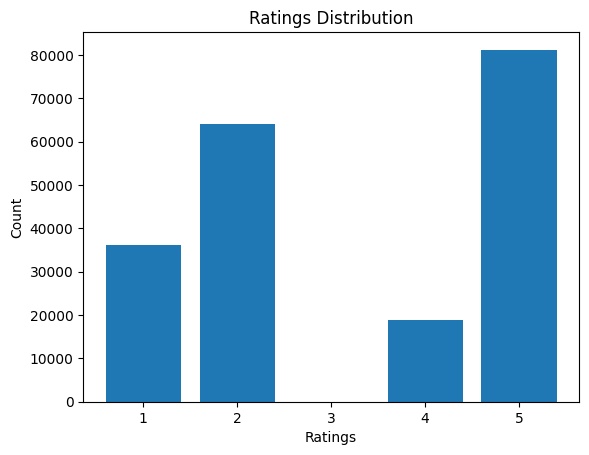

In [11]:
rating_counts = shopping['ratings'].value_counts().sort_index()

plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.title('Ratings Distribution')
plt.show()

## 1-2. 훈련 데이터와 테스트 데이터 분리하기

In [20]:
# 파생컬럼 형성 -> 평점(1~5)에 대하여 1,2점: 부정- 레이블 0  / 4, 5점: 긍정 - 레이블 1

shopping['label'] = shopping['ratings'].map(lambda x: 1 if x > 3 else 0)
# shopping['label'] = np.select([shopping['ratings'] > 3], [1], default=0)

shopping.head(5)

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [21]:
# nunique -> 고유한(unique) 값을 가지는 요소의 개수를 반환

shopping['ratings'].nunique(), shopping['reviews'].nunique(), shopping['label'].nunique()

(4, 199908, 2)

- shopping['reviews']는 200,000개 였으나, nunique()의 결과 199,908개가 고유하다고 나옴 -> 중복이 존재함.

In [22]:
# 중복 제거
shopping.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(shopping))

총 샘플의 수 : 199908


In [23]:
shopping.isnull().sum()    # 결측치는 없음.

ratings    0
reviews    0
label      0
dtype: int64

In [24]:
train_data, test_data = train_test_split(shopping, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


## 1-3. 데이터 정제하기

In [32]:
# 정규표현식을 사용하여 [^ㄱ-ㅎㅏ-ㅣ가-힣 ] => 한글이(ㄱ-ㅎㅏ-ㅣ가-힣) 아닌(^) 문자는 공백으로 바꿔줌.
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [33]:
train_data['reviews'].head()

59666     사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...
12433                            ㅂ불만족 빗이 아픔  멍이피부에 빗질못해주겟네요
146516    이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...
158109                                           적당하고 만족합니다
70219                      편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요
Name: reviews, dtype: object

In [27]:
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


In [28]:
test_data['reviews'].head()

193242                             너무 낮고 솜도 적고 실망스럽습니다
125080                                피부에 뾰루지가 많이 올라와요
122750    배송도 빠르네요 가격대비 좋은것 같아요 첨에는 힘들어하나 조금 지나니 잘 하네요
72927                           재구매입니다 핏도 좋고 착용감도 좋습니다
83890      파손제품 온거 출장같다 오늘 받았는데 현재상황 장난하시는지 택배회사 항의하세요
Name: reviews, dtype: object

## 1-4. 토큰화

In [34]:
okt = Okt()
print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이라고', '차라리', '내', '가', '만드는', '게', '나을', '뻔']


In [35]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들',
             '듯', '지', '임', '게']

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 1-5. 단어와 길이 분포 확인하기

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values) # 부정 평가 단어 사전
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values) # 긍정 평가 단어 사전

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))     # 부정 평가 단어 사전 중에 가장 많이 사용된 단어 20개

[('너무', 13039), ('요', 11784), ('안', 11676), ('배송', 9171), ('그냥', 8518), ('잘', 7817), ('로', 5777), ('했는데', 5692), ('별로', 5549), ('못', 5174), ('제품', 5071), ('으로', 4999), ('생각', 4927), ('좀', 4878), ('사용', 4846), ('하고', 4769), ('ㅠㅠ', 4760), ('구매', 4634), ('보다', 4617), ('맛', 4017)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))     # 긍정 평가 단어 사전 중에 가장 많이 사용된 단어 20개

[('잘', 15302), ('좋아요', 14527), ('배송', 12251), ('너무', 9100), ('재구매', 8573), ('구매', 7186), ('요', 6639), ('사용', 5415), ('가격', 5015), ('으로', 4477), ('같아요', 4434), ('로', 4318), ('좋네요', 4221), ('빠르고', 4025), ('보다', 3955), ('제품', 3950), ('주문', 3815), ('입니다', 3769), ('생각', 3491), ('했어요', 3367)]


긍정 리뷰의 평균 길이 : 10.768613440337008
부정 리뷰의 평균 길이 : 14.101804639739449


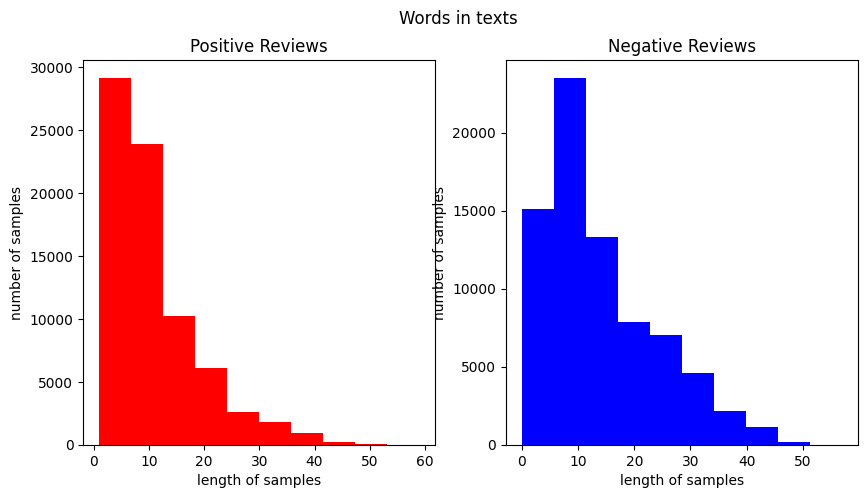

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test= test_data['tokenized'].values
y_test = test_data['label'].values

## 1-6. 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 94361
등장 빈도가 1번 이하인 희귀 단어의 수: 52344
단어 집합에서 희귀 단어의 비율: 55.47207002893144
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.807755335212537


In [ ]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 42019


In [ ]:
# 정수 인코딩
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)      # 문자열에 정수를 부여
X_test = tokenizer.texts_to_sequences(X_test)        # 문자열에 정수를 부여

In [ ]:
X_train[:3]

[[33,
  2263,
  274,
  1,
  294,
  174,
  105,
  78,
  328,
  5,
  9212,
  790,
  5,
  34,
  25,
  1637,
  1036,
  391,
  92,
  6],
 [2867, 1494, 4132, 3159, 3194, 260, 1, 1],
 [14,
  139,
  6114,
  318,
  2720,
  504,
  2,
  7,
  30070,
  946,
  52,
  29,
  100,
  2995,
  170,
  504,
  100,
  2,
  13635,
  7396,
  4010,
  5,
  69,
  18012]]

In [ ]:
X_test[:3]

[[3, 6886, 778, 2095, 151, 2214],
 [260, 7279, 25, 5281],
 [4, 714, 16, 96, 64, 32, 20, 496, 131, 1, 67, 2837, 2, 117]]

## 1-7. 패딩(Padding)

리뷰의 최대 길이 : 59
리뷰의 평균 길이 : 12.43415304373345


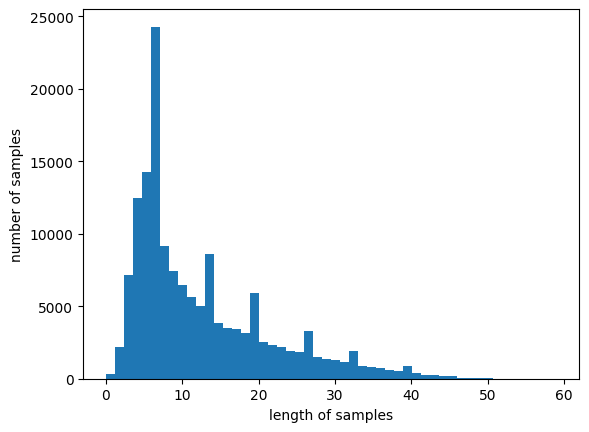

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 만약 max_len을 55로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있을까?
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 2. 학습

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
result = model.fit(X_train, y_train, epochs=15, callbacks=[es], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - 451s 236ms/step - loss: 0.2975 - acc: 0.8848 - val_loss: 0.2630 - val_acc: 0.8991
Epoch 2/15
1875/1875 [==============================] - 429s 229ms/step - loss: 0.2304 - acc: 0.9173 - val_loss: 0.2356 - val_acc: 0.9135
Epoch 3/15
1875/1875 [==============================] - 430s 229ms/step - loss: 0.2058 - acc: 0.9281 - val_loss: 0.2318 - val_acc: 0.9160
Epoch 4/15
1875/1875 [==============================] - 428s 229ms/step - loss: 0.1874 - acc: 0.9361 - val_loss: 0.2359 - val_acc: 0.9153
Epoch 5/15
1875/1875 [==============================] - 427s 228ms/step - loss: 0.1704 - acc: 0.9432 - val_loss: 0.2414 - val_acc: 0.9163
Epoch 6/15
1875/1875 [==============================] - 435s 232ms/step - loss: 0.1553 - acc: 0.9493 - val_loss: 0.2457 - val_acc: 0.9138
Epoch 7/15
1875/1875 [==============================] - 428s 228ms/step - loss: 0.1417 - acc: 0.9539 - val_loss: 0.2523 - val_acc: 0.9138
Epoch 7: early stopping


Text(0, 0.5, 'Loss')

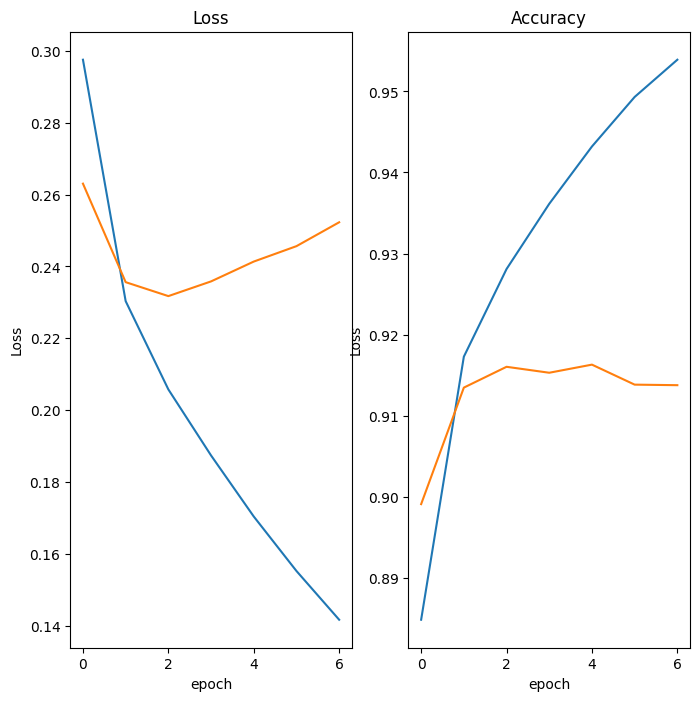

In [ ]:
plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(result.history["loss"], label="Loss")
plt.plot(result.history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(result.history["acc"], label="Accuracy")
plt.plot(result.history["val_acc"], label="Val_Accuracy")
plt.xlabel("epoch")
plt.ylabel("Loss")

# 3. 예측

In [ ]:
# 함수화
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)           # 1. 새로운 단어가 들어오면 한글이 아닌 문자는 삭제
  new_sentence = okt.morphs(new_sentence)                                  # 2. Okt를 통해 토큰화 시켜주고
  new_sentence = [word for word in new_sentence if not word in stopwords]  # 3. 불용어 사전에 없는 토큰들만 토큰으로 사용

  encoded = tokenizer.texts_to_sequences([new_sentence])                   # 4. 정수 인코딩 진행해주고
  pad_new = pad_sequences(encoded, maxlen = max_len)                       # 5. 패딩 진행

  score = float(model.predict(pad_new))                                    # 학습된 모델에 1-5단계를 모두 거친 새 문장을 넣어 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict("배송이 정말 빨라요")

1/1 [==============================] - 1s 688ms/step
87.87% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict("선물로 받으면 쓸 것 같은데 직접 사진 않을 듯.")

1/1 [==============================] - 0s 29ms/step
90.93% 확률로 부정 리뷰입니다.
